In [1]:
import os
import glob
import datetime
import importlib
import statistics
import numpy as np
import pandas as pd
from marcap import marcap_data
import FinanceDataReader as fdr
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from prettytable import PrettyTable

In [2]:
import models.qp as model # 1/PBR + GP/A
#import models.ncav as model # NCAV
#import models.super_value as model # PBR + PCR + PER + PSR
#import models.super_quality as model
#import models.lu_zhang as model

importlib.reload(model)

<module 'models.qp' from '/home/pi/Documents/stock-backtesting/backtest-playground/quantitative-value/models/qp.py'>

In [3]:
MODEL_NAME = 'qp'
#DATA_DIR = '../data/quarterly/3-6-9-12' # quarter
# DATA_DIR = '../data/half-year/2-8' # half year
DATA_DIR = '../data/yearly/8-1'
REBALANCE = 1 # 1: yearly, 2: half-yearly 4: quarterly

In [4]:
df_account = pd.DataFrame(columns=['start_date', 'end_date', 'filepath'])
filepaths = glob.glob(DATA_DIR + "/*.csv")
filepaths = sorted(filepaths)

days = []
for i in range(len(filepaths)):
    if i < len(filepaths) - 1: # exclude last item
        start_date =  os.path.basename(filepaths[i])[:-4]
        end_date =  os.path.basename(filepaths[i + 1])[:-4]
        
        day = {'start_date':start_date, 'end_date':end_date, 'filepath':filepaths[i]}
        days.append(day)

df_account = df_account.append(days)

In [5]:
df_account

,start_date,end_date,filepath
0,2002-08-01,2003-08-01,../data/yearly/8-1/2002-08-01.csv
1,2003-08-01,2004-08-02,../data/yearly/8-1/2003-08-01.csv
2,2004-08-02,2005-08-01,../data/yearly/8-1/2004-08-02.csv
3,2005-08-01,2006-08-01,../data/yearly/8-1/2005-08-01.csv
4,2006-08-01,2007-08-01,../data/yearly/8-1/2006-08-01.csv
5,2007-08-01,2008-08-01,../data/yearly/8-1/2007-08-01.csv
6,2008-08-01,2009-08-03,../data/yearly/8-1/2008-08-01.csv
7,2009-08-03,2010-08-02,../data/yearly/8-1/2009-08-03.csv
8,2010-08-02,2011-08-01,../data/yearly/8-1/2010-08-02.csv
9,2011-08-01,2012-08-01,../data/yearly/8-1/2011-08-01.csv


In [6]:
# 연도별 종목을 구한다.
df_account['stocks'] = df_account.apply(lambda x: model.get_stocks(x.filepath, x.start_date, False), axis=1)

In [7]:
# 연도별 수익률을 구한다.
df_account['yield'] = 0.0
df_account['yields'] = 0.0
df_account['yields'] = df_account['yields'].astype('object')
df_account['delisted'] = 0
df_account['delisted_stocks'] = df_account['yields'].astype('object')

for i in range(len(filepaths)):
    if i < len(filepaths) - 1: # exclude last item
        start_date = df_account.iloc[i].start_date
        end_date = df_account.iloc[i].end_date
        
        df_this_year = pd.read_csv(filepaths[i], dtype={"기업코드":"string", "종목코드":"string"})[['종목코드', '주가']]
        df_next_year = pd.read_csv(filepaths[i + 1], dtype={"기업코드":"string", "종목코드":"string"})[['종목코드', '주가']]
        
        stocks = df_account.iloc[i].stocks   
        yields = []
        
        # 종목별 수익률, 상장폐지 기업 수를 구한다.
        delisted = 0 # 상장폐지 기업 수
        delisted_stocks  = []
        for stock in stocks:
            start_price = df_this_year[df_this_year['종목코드'] == stock]['주가'].iloc[0]
            end_price = df_next_year[df_next_year['종목코드'] == stock]['주가']
            
            if len(end_price) == 0:
                end_price = 0
            else:                    
                end_price = end_price.fillna(0) 
                end_price = end_price.iloc[0]
                
            if end_price == 0: # 가격 정보가 없을 경우 상폐
                delisted += 1
                delisted_stocks.append(stock)
            
            # get yield
            yields.append(end_price / start_price)

        # stock 수익률들의 avg가 total 수익률이 된다. (동일 비중이기 때문에)
        mean_yields = statistics.mean(yields)
        df_account.at[i, 'yield'] = mean_yields
        df_account.at[i, 'yields'] = yields
        df_account.at[i, 'delisted'] = delisted
        df_account.at[i, 'delisted_stocks'] = delisted_stocks
        
        print(start_date, '~', end_date, ":", mean_yields)
        
        #break

2002-08-01 ~ 2003-08-01 : 0.8800222476661446
2003-08-01 ~ 2004-08-02 : 1.046178849695229
2004-08-02 ~ 2005-08-01 : 2.853786099662451
2005-08-01 ~ 2006-08-01 : 1.2004020671638218
2006-08-01 ~ 2007-08-01 : 2.2368028664141812
2007-08-01 ~ 2008-08-01 : 0.8694899215130552
2008-08-01 ~ 2009-08-03 : 1.1459746697578597
2009-08-03 ~ 2010-08-02 : 1.4444868681776335
2010-08-02 ~ 2011-08-01 : 2.2063302078359066
2011-08-01 ~ 2012-08-01 : 1.4617654555959863
2012-08-01 ~ 2013-08-01 : 1.2986769460409477
2013-08-01 ~ 2014-08-01 : 1.304503631641778
2014-08-01 ~ 2015-08-03 : 2.0560129586739726
2015-08-03 ~ 2016-08-01 : 1.578267452323414
2016-08-01 ~ 2017-08-01 : 1.0330638832475
2017-08-01 ~ 2018-08-01 : 1.8637263534525885
2018-08-01 ~ 2019-08-01 : 1.2932781105476583


In [8]:
df_account['total'] = df_account['yield'].cumprod()

In [9]:
df_account['cagr'] = 0.0
for i, row in enumerate(df_account.iterrows()):
    df_account.at[i, 'cagr'] = pow(row[1]['total'], 1/((i+1)/REBALANCE))

In [10]:
df_account

,start_date,end_date,filepath,stocks,yield,yields,delisted,delisted_stocks,total,cagr
0,2002-08-01,2003-08-01,../data/yearly/8-1/2002-08-01.csv,"[010600, 008900, 005610, 025880, 003230, 01457...",0.880022,"[0.8875739644970414, 0.27522522522522525, 0.66...",0,[],0.880022,0.880022
1,2003-08-01,2004-08-02,../data/yearly/8-1/2003-08-01.csv,"[010600, 009460, 003680, 014100, 025880, 00409...",1.046179,"[0.7766666666666666, 0.7991803278688525, 2.113...",0,[],0.920661,0.959511
2,2004-08-02,2005-08-01,../data/yearly/8-1/2004-08-02.csv,"[010600, 017680, 005320, 032860, 016920, 00409...",2.853786,"[1.6251788268955651, 1.96875, 1.30087390761548...",0,[],2.627369,1.379877
3,2005-08-01,2006-08-01,../data/yearly/8-1/2005-08-01.csv,"[010600, 017680, 007980, 046310, 005320, 01447...",1.200402,"[2.183098591549296, 1.812169312169312, 1.10526...",1,[005320],3.153899,1.332637
4,2006-08-01,2007-08-01,../data/yearly/8-1/2006-08-01.csv,"[068290, 007980, 025880, 000440, 008110, 01692...",2.236803,"[2.0201729106628243, 2.3579109062980033, 1.865...",0,[],7.054650,1.478070
5,2007-08-01,2008-08-01,../data/yearly/8-1/2007-08-01.csv,"[017680, 006060, 010600, 045060, 079650, 02588...",0.869490,"[0.5589519650655022, 0.7112195121951219, 0.043...",0,[],6.133947,1.352976
6,2008-08-01,2009-08-03,../data/yearly/8-1/2008-08-01.csv,"[038320, 011080, 005320, 006060, 078520, 01457...",1.145975,"[0.37209302325581395, 0.6292517006802721, 0.98...",0,[],7.029348,1.321259
7,2009-08-03,2010-08-02,../data/yearly/8-1/2009-08-03.csv,"[011080, 017680, 010470, 079650, 007980, 08879...",1.444487,"[0.9081081081081082, 1.1848101265822786, 1.621...",0,[],10.153800,1.336068
8,2010-08-02,2011-08-01,../data/yearly/8-1/2010-08-02.csv,"[011080, 033340, 032860, 088790, 011090, 07965...",2.206330,"[0.8857142857142857, 1.0733333333333333, 22.61...",0,[],22.402636,1.412646
9,2011-08-01,2012-08-01,../data/yearly/8-1/2011-08-01.csv,"[011080, 038320, 033340, 044380, 091440, 01109...",1.461765,"[1.7473118279569892, 0.0, 1.1770186335403727, ...",1,[038320],32.747400,1.417482


In [11]:
def get_win_rate(yield_rates):
    return sum([yield_rate > 1.0 for yield_rate in yield_rates]) / len(yield_rates)

df_account['win_rate'] = df_account.apply(lambda x: get_win_rate(x['yields']), axis=1)

In [12]:
df_account['best_corp'] = df_account.apply(lambda x: max(x['yields']), axis=1)
df_account['worst_corp'] = df_account.apply(lambda x: min(x['yields']), axis=1)

In [13]:
df_account['best_stock_code'] = df_account.apply(lambda x: x['stocks'][np.argmax(x['yields'])], axis=1)
df_account['worst_stock_code'] = df_account.apply(lambda x: x['stocks'][np.argmin(x['yields'])], axis=1)

/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


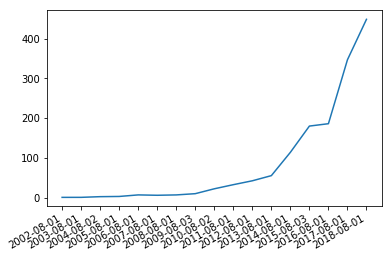

In [14]:
fig, ax = plt.subplots()
ax.plot_date(df_account['start_date'], df_account['total'], marker='', linestyle='-')
fig.autofmt_xdate()
plt.show()

In [15]:
cagrs = df_account['cagr']
rolling_cagrs = []
ROLLING = 3
for i in range(len(cagrs)):
    if i - 3 < 0:
        rolling_cagr = np.mean(cagrs[0:i])
    else:
        rolling_cagr = np.mean(cagrs[i - 3:i])
    rolling_cagrs.append(rolling_cagr)

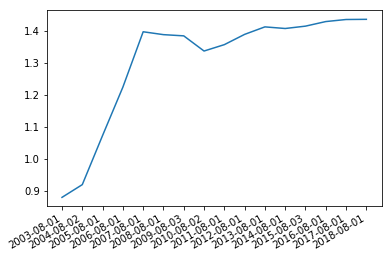

In [16]:
fig, ax = plt.subplots()
ax.plot_date(df_account['start_date'], rolling_cagrs, marker='', linestyle='-')
fig.autofmt_xdate()
plt.show()

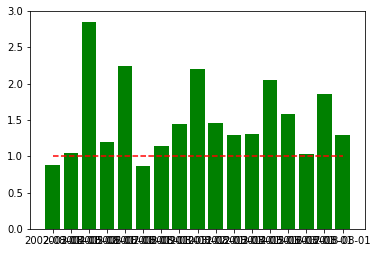

In [17]:
# fig, ax = plt.subplots()
# ax.plot_date(df_account['start_date'], df_account['yield'])
# fig.autofmt_xdate()

plt.bar(df_account['start_date'], df_account['yield'], color='green')

h_line = np.array([1.0 for i in range(len(df_account['start_date']))])
plt.plot(df_account['start_date'], h_line, 'r--') 

plt.show()

In [18]:
# 가격 정보가 없는 경우 상폐로 처리했음. 실제로 상폐까지는 아니고 거래정지인 경우가 있음
delisted_stocks = sum(df_account['delisted'])

In [19]:
cagr = pow(df_account['total'][len(df_account) - 1], 1/(len(df_account)/REBALANCE))

In [20]:
# MDD, MDD duration 구하기
max_yield = -100.0
min_yield = 0.0
mdd = 0.0
mdd_duration = 0 

dd = 0.0
dd_duration = 0
for val in df_account['total']:
    if val > max_yield:
        max_yield = val
        min_yield = val
        dd_duration = 0
        continue
    
    if val < min_yield:
        min_yield = val
        dd = (1.0 - min_yield / max_yield) * 100.0
        dd_duration += 1
        
        if dd > mdd:
            mdd = dd
        if dd_duration > mdd_duration:
            mdd_duration = dd_duration
            
if REBALANCE == 2:
    mdd_duration *= 6
elif REBALANCE == 4:
    mdd_duration *= 3

In [21]:
# 수익률 표준편차 구하기
filetered_yield = list(df_account['yield']).copy()

# outlier 제거
filetered_yield.remove(max(filetered_yield))
filetered_yield.remove(min(filetered_yield))

std_yield = statistics.stdev(filetered_yield)

In [22]:
# 평균 승률 
yields = []
for i in range(len(df_account)):
    yields.extend(df_account.iloc[i]['yields'])
    
win_rate = (sum([val > 1.0 for val in yields]) / len(yields)) * 100.0

In [23]:
t = PrettyTable(['Rebalance', 'CAGR', 'MDD', 'MDD duration', 'STD', 'Delisted', 'Win rate', 'Note'])
t.add_row([os.path.basename(DATA_DIR),
           "%.2f%%" % ((cagr - 1.0) * 100.0),
           "%.2f%%" % (mdd),
           mdd_duration,
           "%.4f" % std_yield,
           delisted_stocks,
           "%.2f%%" % win_rate,
           ""
          ])
print(t)

+-----------+--------+--------+--------------+--------+----------+----------+------+
| Rebalance |  CAGR  |  MDD   | MDD duration |  STD   | Delisted | Win rate | Note |
+-----------+--------+--------+--------------+--------+----------+----------+------+
|    8-1    | 43.21% | 13.05% |      1       | 0.4330 |    11    |  63.33%  |      |
+-----------+--------+--------+--------------+--------+----------+----------+------+


In [24]:
# 수수료 고려
df_account['fee_yield'] = df_account['yield'] * 0.99
df_account['fee_total'] = df_account['fee_yield'].cumprod()
pow(df_account['fee_total'][len(df_account) - 1], 1/(len(df_account)/REBALANCE))

1.4177759443351428